In [1]:
import re
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
print('')

[nltk_data] Downloading package stopwords to /home/ashari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv')
df = df[['type', 'text']]
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


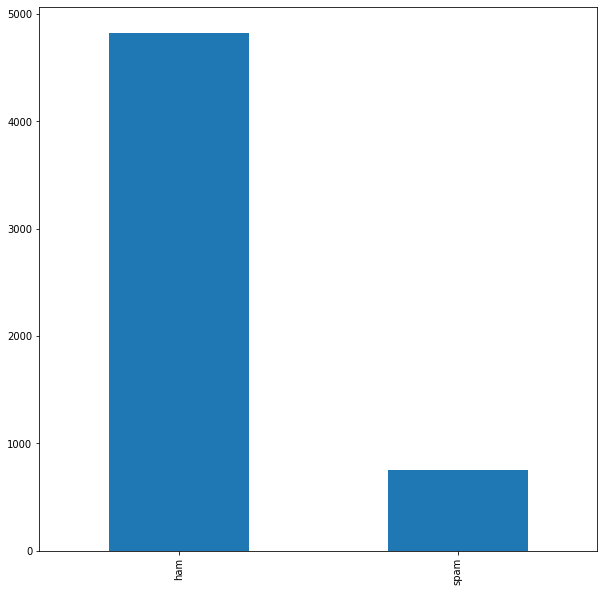

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
df['type'].value_counts().plot.bar(ylim=0)

In [4]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')

In [5]:
category = pd.get_dummies(df.type)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='type')

In [6]:
text = df_baru['text'].values
label = df_baru[['ham', 'spam']].values

In [7]:
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
     
tokenizer = Tokenizer(num_words=1000, oov_token='OOV')
tokenizer.fit_on_texts(text_latih) 
tokenizer.fit_on_texts(text_test)
     
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)
     
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [9]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [10]:
num_epochs = 30

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nAkurasi telah mencapai >90%!")
            self.model.stop_training = True
callbacks = myCallback()


history = model.fit(padded_latih, label_latih, epochs=num_epochs, callbacks=[callbacks],
                    validation_data=(padded_test, label_test), verbose=2)

Epoch 1/30

Akurasi telah mencapai >90%!
140/140 - 7s - loss: 0.2334 - accuracy: 0.9219 - val_loss: 0.0674 - val_accuracy: 0.9821


# Confusion Matrix

In [11]:
y_pred = model.predict_classes(padded_test)
label = tf.argmax(label_test, axis = 1)
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix")
print(confusion_matrix(label, y_pred))
print("")
print("\t\t\tClassification Reports")
print(classification_report(label, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix
[[962   3]
 [ 17 133]]

			Classification Reports
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [13]:
print('Detect Spam or Ham')
print('##################')
more = "yes"
while(more=="yes"):
    new_text = [input('Enter Message')]
    df1 = pd.DataFrame(new_text) 
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    def clean_text(text):
        """
            text: a string
        
            return: modified initial string
        """
        text = text.lower() # lowercase text
        text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = text.replace('x', '')
    #    text = re.sub(r'\W+', '', text)
        text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
        return text
    df1 = df1[0].apply(clean_text)
    df1 = df1.str.replace('\d+', '')
    new_tokenizer = Tokenizer(num_words=1000, oov_token='OOV')
    new_tokenizer.fit_on_texts(new_text) 
    new_sekuens = tokenizer.texts_to_sequences(new_text)
    new_padded = pad_sequences(new_sekuens)
    result = model.predict(new_padded)
    if result[0,0] == result.max():
        result = "Ham"
        print('The message type is {}'.format(result))
        print('')
    else:
        result = "Spam"
        print('The message type is {}\n'.format(result))
        print('')
    more = input('Try another message? (yes/no)').lower()
    if(more!="yes"):
        break

Detect Spam or Ham
##################


Enter Message WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.


The message type is Spam




Try another message? (yes/no) yes
Enter Message Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


The message type is Spam




Try another message? (yes/no) yes
Enter Message As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


The message type is Ham



Try another message? (yes/no) yes
Enter Message I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.


The message type is Ham



Try another message? (yes/no) no
